# Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import seaborn as sns; sns.set()

# Load dataset
from statsmodels.datasets import sunspots
df = sunspots.load_pandas().data
df

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


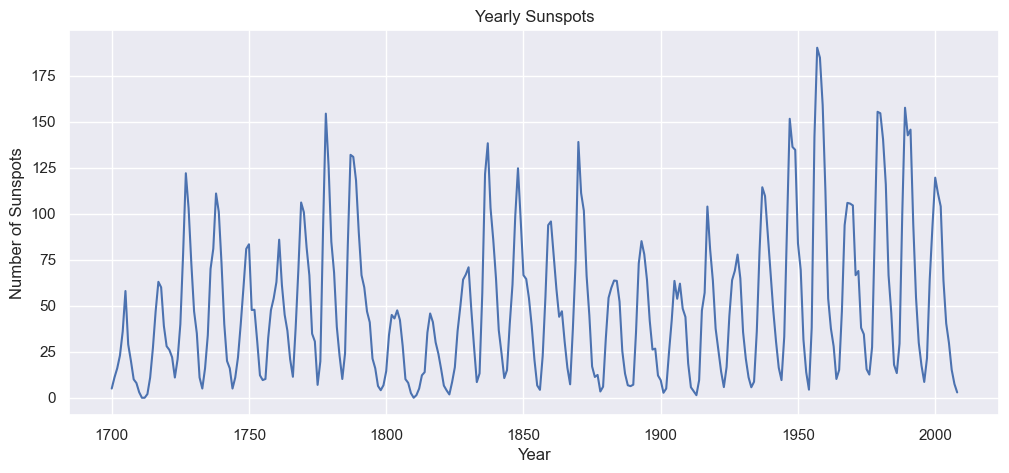

In [2]:
x = df[['SUNACTIVITY']]

plt.figure(figsize=(12, 5))
plt.plot(x)
plt.title('Yearly Sunspots')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.xticks(np.arange(0, 309, 50), np.arange(1700, 2009, 50))
plt.show()

# ADF Analysis

## is stationary?

In [3]:
def stationarity_check(x):
    adf = adfuller(x)
    print('ADF Statistic:', adf[0])
    print('p-value:', adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print(f'\t{key}: {value}')

stationarity_check(x)

ADF Statistic: -2.8377807249381966
p-value: 0.05307642172812041
Critical Values:
	1%: -3.4523371197407404
	5%: -2.871222860740741
	10%: -2.571929211111111


The ADF statistic is -2.83 with a p-value of 0.053. Technically, we fail to reject the null hypothesis that the time series is non-stationary at significance level $α=0.05$ but can reject it at $α=0.1$.

Practically, the p-value is very close to $0.05$ as well so the time series is likely to be stationary. For this reason. we will use $d=1$ in the ARIMA model for 1 degree of differencing.

# ACF & PACF


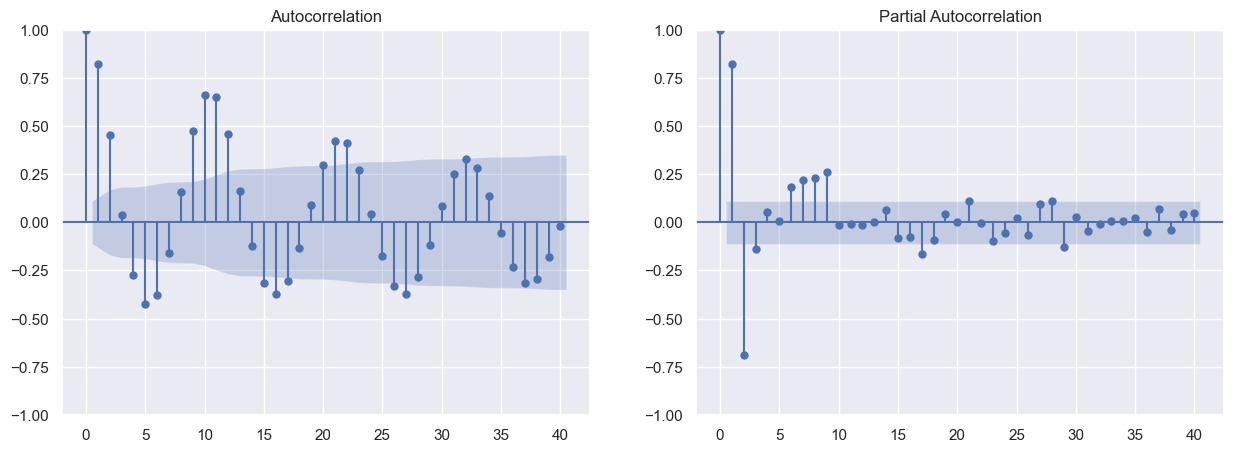

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(x, lags=40, ax=axs[0])
plot_pacf(x, lags=40, ax=axs[1])
plt.show()

As it appears from the ACF plot, we can assume the first 6 lags as significant, so we can use $q=6$. There also seems to be periodicity, with a period of 12, so we can use $s=12$ for the seasonal component.

Furthermore, from the PACF plot we can see that the first 3 lags are most significant by a large difference, so we'll use $p=3$.

# STL Analysis

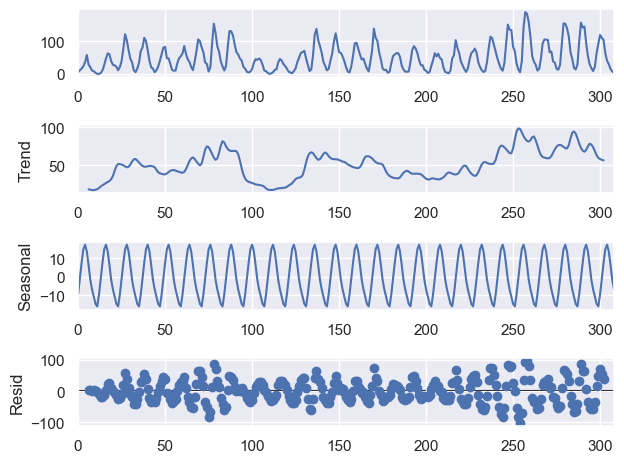

In [15]:
decomposition = seasonal_decompose(x, model='additive', period=12)
decomposition.plot()
plt.show()

# ARIMA Model:
$p=3$, $q=6$, $d=1$, $s=12$

(choices explained above)

In [7]:
train_size = int(len(x) * 0.8)
train, test = x.iloc[:train_size], x.iloc[train_size:]

arima = ARIMA(train, order=(3, 1, 6), seasonal_order=(1, 1, 1, 12)).fit()
arima_forecast = arima.forecast(steps=len(test))

arima.summary()

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        SUNACTIVITY   No. Observations:                  247
Model:             ARIMA(3, 1, 6)x(1, 1, [1], 12)   Log Likelihood                -968.784
Date:                            Thu, 11 Apr 2024   AIC                           1961.567
Time:                                    22:13:47   BIC                           2003.031
Sample:                                         0   HQIC                          1978.285
                                            - 247                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6741      3.883      0.174      0.862      -6.936       8.284
ar.L2          0.5970      6.297      0.095      0.924     -11.745      12.939
ar.L3         -0.8956      3.653     -0.245      0.806      -8.055       6.263
ma.L1         -0.4483      3.891     -0.115      0.908      -8.075       7.178
ma.L2         -0.9508      5.421     -0.175      0.861     -11.575       9.674
ma.L3          0.4429      1.454      0.305      0.761      -2.406       3.292
ma.L4          0.3001      0.352      0.853      0.393      -0.389       0.989
ma.L5          0.0539      0.823      0.066      0.948      -1.560       1.668
ma.L6         -0.1478      0.577     -0.256      0.798      -1.278       0.982
ar.S.L12       0.0443      0.101      0.437      0.662      -0.154       0.243
ma.S.L12      -0.9728      0.289     -3.364      0.001      -1.540      -0.406
sigma2       201.9483     52.904      3.817      0.000      98.258     305.639
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.76
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.29
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# LSTM Model

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_normalized = scaler.fit_transform(train)
test_normalized = scaler.transform(test)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train, y_train = create_dataset(train_normalized, train_normalized, time_steps)
X_test, y_test = create_dataset(test_normalized, test_normalized, time_steps)

lstm = Sequential()
lstm.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

lstm_forecast = scaler.inverse_transform(lstm.predict(X_test))

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


# Simple RNN

In [9]:
rnn = Sequential()
rnn.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn.add(Dense(units=1))
rnn.compile(optimizer='adam', loss='mean_squared_error')
rnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

rnn_forecast = scaler.inverse_transform(rnn.predict(X_test))

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


# Plot Actual and Predicted values from all models

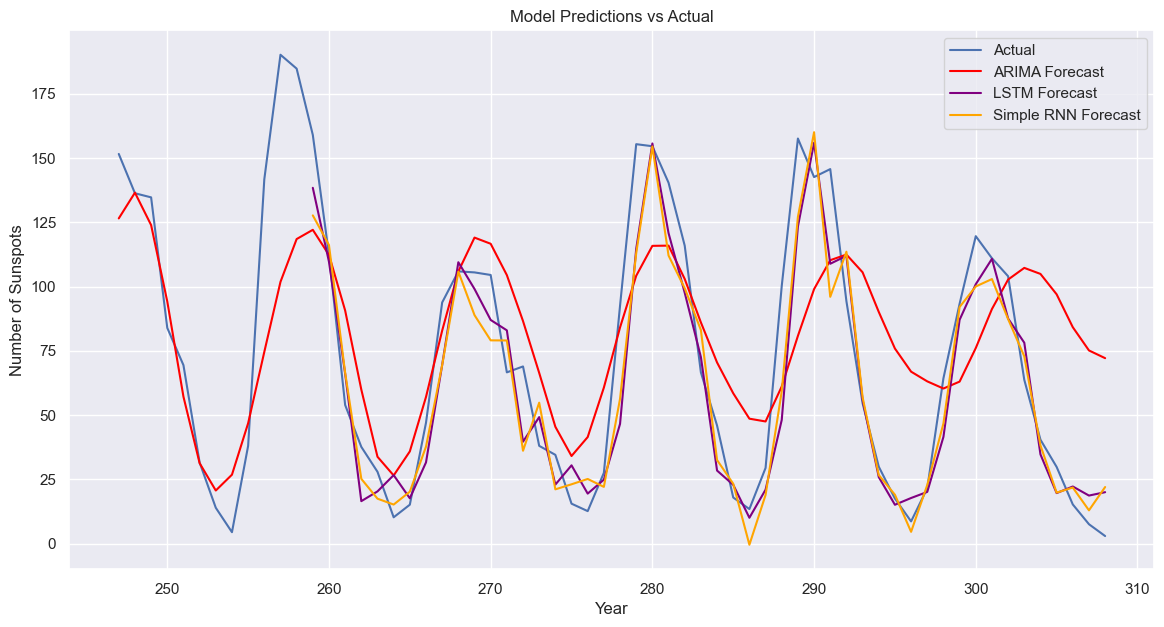

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index[time_steps:], lstm_forecast, label='LSTM Forecast', color='purple')
plt.plot(test.index[time_steps:], rnn_forecast, label='Simple RNN Forecast', color='orange')

plt.legend()
plt.title('Model Predictions vs Actual')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.show()

We can see that the RNN-based models have significantly better predictions than the ARIMA model. The weaknesses of the ARIMA model are clear, since it doesn't have enough capacity to capture the complexity of the time series. This is apparent from the prediction plot, where the ARIMA forecast has a higher bias and cannot express the full variance in the data, in contrast to the RNN-based models.

# Plot Performance metric for each method

ARIMA Mean Squared Error: 1460.059109625634
LSTM Mean Squared Error: 339.7769884647828
Simple RNN Mean Squared Error: 348.66086122187176


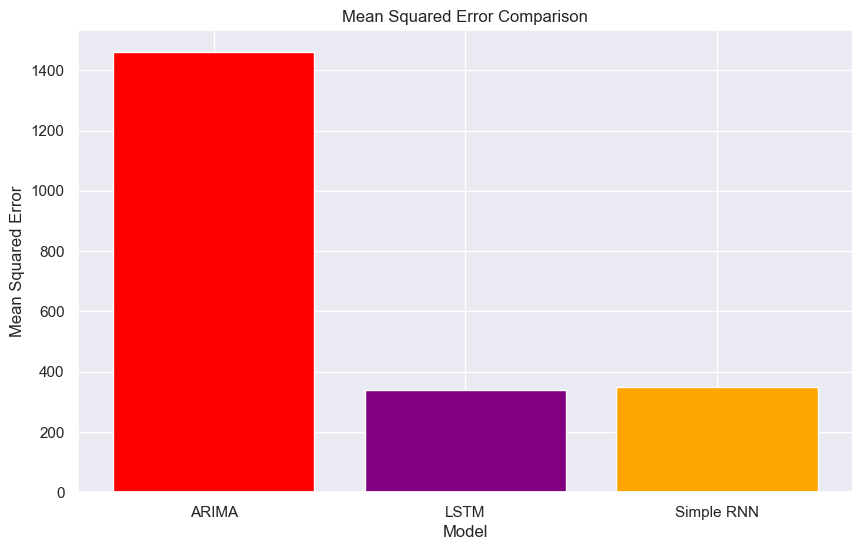

In [11]:
arima_mse = mean_squared_error(test, arima_forecast)
print('ARIMA Mean Squared Error:', arima_mse)

lstm_mse = mean_squared_error(test[time_steps:], lstm_forecast)
print('LSTM Mean Squared Error:', lstm_mse)

rnn_mse = mean_squared_error(test[time_steps:], rnn_forecast)
print('Simple RNN Mean Squared Error:', rnn_mse)

models = ['ARIMA', 'LSTM', 'Simple RNN']
mse_values = [arima_mse, lstm_mse, rnn_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['red', 'purple', 'orange', 'green'])
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.show()

We can further confirm how better the RNN-based models are, by looking at the performance metric, where the ARIMA model has a significantly higher MSE. As expected, the LSTM model has the best performance, however it is very closely followed by the simple RNN and their difference is not apparent to the naked eye in the prediction plot.